In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout, BatchNormalization # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_columns', None) #so the maximum number of columns are displayed in .head()

In [3]:
#Loading the dataset on a datafdrame data
data = pd.read_csv("/kaggle/input/android-malware-detection/Android_Malware.csv")

/tmp/ipykernel_47/2559244498.py:2: DtypeWarning: Columns (56,58,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/android-malware-detection/Android_Malware.csv")


In [4]:
data.columns = [i.strip() for i in data.columns] # stripping all the whitespaces from the column names

In [5]:
print(data.isnull().sum())
data = data.dropna()

Unnamed: 0        0
Flow ID           1
Source IP         0
Source Port       0
Destination IP    0
                 ..
Idle Mean         4
Idle Std          4
Idle Max          4
Idle Min          4
Label             0
Length: 86, dtype: int64


In [6]:
#Dropping Android_Adware and Android_Scareware
data['Label'].unique()
labels_to_remove = ['Android_Adware', 'Android_Scareware']
data = data[~data['Label'].isin(labels_to_remove)]
for column in data.columns:
    if 'Timestamp' in column:
        data = data.drop(column, axis = 1)

In [7]:
for column in data.columns:
    if len(data[column].unique()) > 1:
        count = 0
        if str(data[column].unique()[0]) != str(data[column].unique()[1]):
                count += 1
        if (count == 0):
            print('Same Unique Values : ',column)
            data = data.drop(column, axis = 1)
    elif len(data[column].unique()) == 1:
        print('Only 1 value : ', column)
        data = data.drop(column, axis = 1)

Only 1 value :  Bwd PSH Flags
Only 1 value :  Fwd URG Flags
Only 1 value :  Bwd URG Flags
Only 1 value :  RST Flag Count
Same Unique Values :  CWE Flag Count
Only 1 value :  ECE Flag Count
Same Unique Values :  Fwd Avg Bytes/Bulk
Only 1 value :  Fwd Avg Packets/Bulk
Only 1 value :  Fwd Avg Bulk Rate
Only 1 value :  Bwd Avg Bytes/Bulk
Only 1 value :  Bwd Avg Packets/Bulk
Only 1 value :  Bwd Avg Bulk Rate


In [8]:
data['Down/Up Ratio']  = [float(x) for x in data['Down/Up Ratio'].values]

In [9]:
data.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
264525,0,10.42.0.151-40.69.219.199-35131-443-6,10.42.0.151,35131,40.69.219.199,443.0,6.0,12109,2,0,85.0,0.0,85.0,0.0,42.500000,60.104076,0.0,0.0,0.000000,0.000000,7019.572219,165.166405,12109.000000,0.000000,12109.0,12109.0,12109.0,12109.0,0.000000,12109.0,12109.0,0.0,0.0,0.000000,0.0,0.0,1.0,64,0,165.166405,0.000000,0.0,85.0,56.666667,49.074773,2408.333333,0.0,1.0,0.0,1.0,0.0,0.0,85.000000,42.500000,0.000000,64.0,2.0,85.0,0.0,0.0,1550.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264526,1,10.42.0.151-40.69.219.199-35131-443-6,40.69.219.199,443,10.42.0.151,35131.0,6.0,43,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,46511.627907,43.000000,0.000000,43.0,43.0,43.0,43.0,0.000000,43.0,43.0,0.0,0.0,0.000000,0.0,0.0,0.0,64,0,46511.627907,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,64.0,2.0,0.0,0.0,0.0,510.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264527,2,10.42.0.151-40.122.44.96-54930-443-6,10.42.0.151,54930,40.122.44.96,443.0,6.0,14678,2,0,85.0,0.0,85.0,0.0,42.500000,60.104076,0.0,0.0,0.000000,0.000000,5790.979698,136.258346,14678.000000,0.000000,14678.0,14678.0,14678.0,14678.0,0.000000,14678.0,14678.0,0.0,0.0,0.000000,0.0,0.0,1.0,64,0,136.258346,0.000000,0.0,85.0,56.666667,49.074773,2408.333333,0.0,1.0,0.0,1.0,0.0,0.0,85.000000,42.500000,0.000000,64.0,2.0,85.0,0.0,0.0,1550.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264528,3,10.42.0.151-40.122.44.96-54930-443-6,40.122.44.96,443,10.42.0.151,54930.0,6.0,43,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,46511.627907,43.000000,0.000000,43.0,43.0,43.0,43.0,0.000000,43.0,43.0,0.0,0.0,0.000000,0.0,0.0,0.0,64,0,46511.627907,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,64.0,2.0,0.0,0.0,0.0,509.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware
264529,4,10.42.0.151-52.179.153.195-53215-443-6,10.42.0.151,53215,52.179.153.195,443.0,6.0,3355709,11,7,1290.0,5430.0,869.0,0.0,117.272727,263.158542,1448.0,0.0,775.714286,672.413245,2002.557433,5.363993,197394.647059,653868.357763,2731778.0,6.0,3355709.0,335570.9,843621.265168,2731778.0,13.0,542766.0,90461.0,100811.101629,200127.0,6.0,0.0,360,232,3.277996,2.085997,0.0,1448.0,353.684211,547.317403,299556.339181,0.0,0.0,1.0,0.0,0.0,0.0,373.333333,117.272727,775.714286,360.0,11.0,1290.0,7.0,5430.0,65535.0,510.0,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_SMS_Malware


In [10]:
from category_encoders import TargetEncoder

In [11]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
x = data.drop(['Label'], axis=1)

In [13]:
y = [1 if label == "Android_SMS_Malware" else 0 for label in data['Label'].values]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [15]:
# Apply target encoding only to training data
encoder = TargetEncoder()
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train, y_train), columns=X_train.columns)
X_test_encoded = pd.DataFrame(encoder.transform(X_test), columns=X_test.columns)

In [16]:
# Apply scaling only to training data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [101]:
X_train_scaled = np.reshape(X_train_scaled, ( X_train_scaled.shape[0], 1 , X_train_scaled.shape[1] ))
X_test_scaled = np.reshape(X_test_scaled, ( X_test_scaled.shape[0], 1 , X_test_scaled.shape[1] ))

In [102]:
model = Sequential() # initializing model
model.add(LSTM(128,return_sequences=True,input_shape = (1, X_train_scaled.shape[2]), activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True, activation = "tanh"))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True, activation = "tanh"))
model.add(Flatten())
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units  = 32, activation='relu'))
# output layer with softmax activation
model.add(Dense(units=1,activation='sigmoid'))

# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [103]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = model.fit(X_train_scaled, np.array(y_train), epochs=300, batch_size=500,
                    validation_data=[X_test_scaled, np.array(y_test)], callbacks = [callback])

Epoch 1/300
128/128 [==============================] - 57s 408ms/step - loss: 0.4578 - accuracy: 0.7891 - precision_3: 0.7805 - recall_3: 0.9946 - val_loss: 0.3394 - val_accuracy: 0.8971 - val_precision_3: 0.8874 - val_recall_3: 0.9861
Epoch 2/300
128/128 [==============================] - 1s 9ms/step - loss: 0.0194 - accuracy: 0.9944 - precision_3: 0.9961 - recall_3: 0.9962 - val_loss: 0.4664 - val_accuracy: 0.8906 - val_precision_3: 0.8738 - val_recall_3: 0.9960
Epoch 3/300
128/128 [==============================] - 1s 9ms/step - loss: 0.0130 - accuracy: 0.9953 - precision_3: 0.9960 - recall_3: 0.9977 - val_loss: 0.6103 - val_accuracy: 0.8859 - val_precision_3: 0.8686 - val_recall_3: 0.9965
Epoch 4/300
128/128 [==============================] - 1s 9ms/step - loss: 0.0115 - accuracy: 0.9956 - precision_3: 0.9960 - recall_3: 0.9981 - val_loss: 0.5044 - val_accuracy: 0.8865 - val_precision_3: 0.8694 - val_recall_3: 0.9962
Epoch 5/300
128/128 [==============================] - 1s 9ms/ste

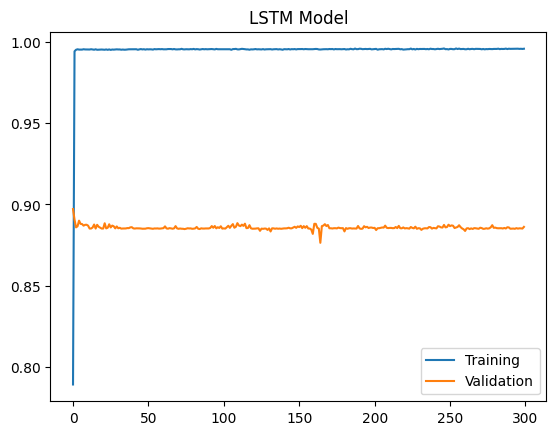

In [105]:
plt.plot(history.history['accuracy'], label = "Training")
plt.plot(history.history['val_accuracy'], label = "Validation")
plt.title('LSTM Model')
plt.legend()

# Applying SMOTE 

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [19]:
from collections import Counter

# Count the occurrences of each class in y_train_smote
class_counts = Counter(y_train_smote)
print(class_counts)


Counter({0: 47176, 1: 47176})


## Feature Selection

In [20]:
random_search_selected_features = ['Flow IAT Mean', 'Average Packet Size', 'Subflow Bwd Bytes', 'Flow ID', 'Fwd Packet Length Mean', 'Bwd IAT Mean', 'Total Length of Fwd Packets', 'Down/Up Ratio', 'Bwd Packet Length Max', 'Flow Duration', 'Min Packet Length', 'Destination Port', 'Packet Length Mean', 'Bwd IAT Min', 'Fwd Packet Length Min', 'Source IP', 'Fwd Packet Length Std', 'Flow IAT Std', 'Bwd IAT Total', 'Idle Min', 'Flow Packets/s', 'Active Std']
simulated_annealing_selected_features = ['Active Std', 'Packet Length Mean', 'Avg Bwd Segment Size', 'Subflow Bwd Packets', 'Total Fwd Packets', 'Idle Min', 'Average Packet Size', 'Subflow Bwd Bytes', 'Fwd Packet Length Mean', 'min_seg_size_forward', 'Idle Std', 'Fwd IAT Mean', 'Init_Win_bytes_backward', 'Bwd IAT Min', 'Fwd Packet Length Std', 'Active Max', 'Fwd Packet Length Min', 'act_data_pkt_fwd', 'Fwd IAT Std', 'Avg Fwd Segment Size', 'Source Port', 'Bwd IAT Total', 'Bwd Packet Length Std', 'Max Packet Length', 'Fwd Packet Length Max', 'Source IP', 'Fwd IAT Max', 'Flow IAT Std', 'Bwd Packets/s', 'Destination IP', 'Protocol', 'Total Backward Packets', 'Packet Length Std', 'Active Mean', 'Min Packet Length', 'Destination Port', 'URG Flag Count', 'Total Length of Bwd Packets', 'SYN Flag Count', 'PSH Flag Count', 'Bwd IAT Mean', 'Bwd Header Length', 'Fwd Header Length', 'Total Length of Fwd Packets', 'Down/Up Ratio', 'Bwd IAT Std', 'Flow Bytes/s', 'Fwd Header Length.1', 'Fwd IAT Min', 'Idle Max', 'Fwd IAT Total', 'Flow Duration', 'Idle Mean', 'Fwd PSH Flags']
genetic_search_selected_features = [
    'Source Port', 'min_seg_size_forward', 'Min Packet Length', 'Bwd Packet Length Std',
    'Bwd IAT Mean', 'Fwd Packets/s', 'Bwd Packets/s', 'Total Length of Bwd Packets',
    'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Fwd IAT Max', 'Bwd IAT Max',
    'Fwd Header Length.1', 'Protocol', 'Total Length of Fwd Packets', 'URG Flag Count',
    'Fwd Packet Length Mean', 'Init_Win_bytes_forward', 'Bwd Packet Length Min',
    'Fwd IAT Mean', 'Flow Bytes/s', 'Down/Up Ratio', 'Active Std', 'Avg Fwd Segment Size',
    'Fwd IAT Total', 'Fwd Packet Length Std', 'Subflow Bwd Packets', 'Flow ID',
    'Fwd Packet Length Max', 'Bwd IAT Min', 'Idle Min', 'Flow IAT Mean', 'Subflow Bwd Bytes',
    'Bwd Packet Length Mean', 'Destination Port', 'Average Packet Size', 'Source IP',
    'Active Min', 'Flow IAT Min', 'Fwd Packet Length Min', 'Total Fwd Packets', 'Flow Packets/s',
    'Fwd Header Length', 'Packet Length Variance', 'Bwd IAT Std', 'Subflow Fwd Packets'
]



In [27]:
def run_models(X_train, X_test, y_train, y_test, feature_set_name, feature_selection_method):
    # Update X_train and X_test to include only the selected features
    X_train_selected = X_train_smote[feature_set_name]
    X_test_selected = X_test_scaled[feature_set_name]
    X_train_selected = np.reshape(X_train_selected, ( X_train_selected.shape[0], 1 , X_train_selected.shape[1] ))
    X_test_selected = np.reshape(X_test_selected, ( X_test_selected.shape[0], 1 , X_test_selected.shape[1] ))

    best_estimators = {}
    roc_auc_scores = {}
    plt.figure()
    model = Sequential() # initializing model
    model.add(LSTM(128,return_sequences=True,input_shape = (1, X_train_selected.shape[2]), activation="tanh"))
    model.add(Dropout(0.2))
    model.add(LSTM(64,return_sequences=True, activation = "tanh"))
    model.add(Dropout(0.2))
    model.add(LSTM(32,return_sequences=True, activation = "tanh"))
    model.add(Flatten())
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(units  = 32, activation='relu'))
    # output layer with softmax activation
    model.add(Dense(units=1,activation='sigmoid'))

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
    history = model.fit(X_train_selected, np.array(y_train), epochs=150, batch_size=500,
                validation_split=0.2, callbacks = [callback])

    plt.plot(history.history['accuracy'], label = "Training")
    plt.plot(history.history['val_accuracy'], label = "Validation")
    plt.title(f'LSTM Model with {feature_selection_method}')
    plt.legend()

    # Predict probabilities for the test data
    y_probs = model.predict_proba(X_test_selected)[:, 1]
    y_pred = model.predict(X_test_selected)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[model_name] = roc_auc

     # Aggregate ROC curve data for each model
    plt.plot(fpr, tpr, label=f'{feature_selection_method} (AUC = {roc_auc:.2f})')

    # Print Classification Report
    print(f"Classification report for {feature_selection_method}:\n{classification_report(y_test, y_pred)}")

    # Print Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {feature_selection_method}:\n{cm}\n")

    # Print AUC
    print(f"AUC for {feature_selection_method}: {roc_auc:.2f}\n")
    # Finalizing the ROC plot
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Evaluating Random Search Selected Features
Epoch 1/150
151/151 [==============================] - 8s 14ms/step - loss: 0.3541 - accuracy: 0.8178 - val_loss: 0.0131 - val_accuracy: 0.9968
Epoch 2/150
151/151 [==============================] - 1s 7ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0185 - val_accuracy: 0.9933
Epoch 3/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0152 - accuracy: 0.9944 - val_loss: 0.0203 - val_accuracy: 0.9929
Epoch 4/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0141 - accuracy: 0.9945 - val_loss: 0.0159 - val_accuracy: 0.9944
Epoch 5/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0137 - accuracy: 0.9948 - val_loss: 0.0190 - val_accuracy: 0.9931
Epoch 6/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.0184 - val_accuracy: 0.9932
Epoch 7/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0135 - accuracy: 0.99

AttributeError: 'Sequential' object has no attribute 'predict_proba'

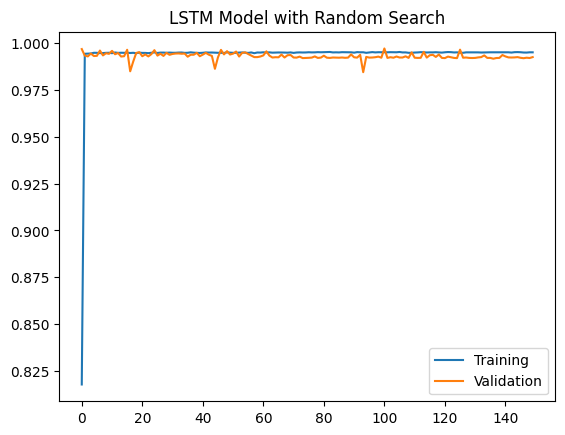

In [28]:
print("Evaluating Random Search Selected Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, random_search_selected_features, "Random Search")

Evaluating Random simulated_annealing Features
Epoch 1/150
151/151 [==============================] - 8s 15ms/step - loss: 0.5726 - accuracy: 0.6812 - val_loss: 0.6741 - val_accuracy: 0.5639
Epoch 2/150
151/151 [==============================] - 1s 8ms/step - loss: 0.4443 - accuracy: 0.7693 - val_loss: 0.6617 - val_accuracy: 0.5657
Epoch 3/150
151/151 [==============================] - 1s 7ms/step - loss: 0.4375 - accuracy: 0.7690 - val_loss: 0.7151 - val_accuracy: 0.5259
Epoch 4/150
151/151 [==============================] - 1s 8ms/step - loss: 0.4352 - accuracy: 0.7716 - val_loss: 0.6285 - val_accuracy: 0.5850
Epoch 5/150
151/151 [==============================] - 1s 8ms/step - loss: 0.4335 - accuracy: 0.7714 - val_loss: 0.5045 - val_accuracy: 0.8399
Epoch 6/150
151/151 [==============================] - 1s 8ms/step - loss: 0.4323 - accuracy: 0.7722 - val_loss: 0.5701 - val_accuracy: 0.7505
Epoch 7/150
151/151 [==============================] - 1s 8ms/step - loss: 0.4318 - accuracy: 

AttributeError: 'Sequential' object has no attribute 'predict_proba'

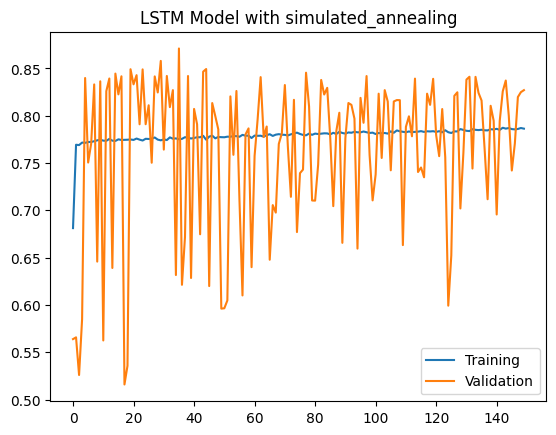

In [29]:
print("Evaluating Random simulated_annealing Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, simulated_annealing_selected_features, "simulated_annealing")

Evaluating Random genetic_search Features
Epoch 1/150
151/151 [==============================] - 8s 15ms/step - loss: 0.3495 - accuracy: 0.8173 - val_loss: 0.0140 - val_accuracy: 0.9971
Epoch 2/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0123 - val_accuracy: 0.9948
Epoch 3/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0138 - accuracy: 0.9947 - val_loss: 0.0167 - val_accuracy: 0.9913
Epoch 4/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0143 - accuracy: 0.9943 - val_loss: 0.0185 - val_accuracy: 0.9926
Epoch 5/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0122 - accuracy: 0.9949 - val_loss: 0.0185 - val_accuracy: 0.9926
Epoch 6/150
151/151 [==============================] - 1s 8ms/step - loss: 0.0117 - accuracy: 0.9947 - val_loss: 0.0182 - val_accuracy: 0.9918
Epoch 7/150
151/151 [==============================] - 1s 7ms/step - loss: 0.0117 - accuracy: 0.994

AttributeError: 'Sequential' object has no attribute 'predict_proba'

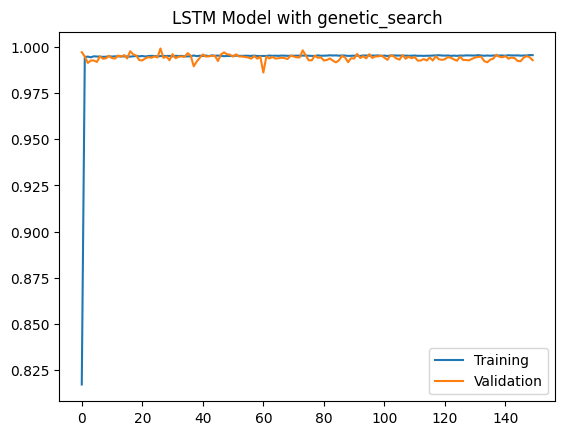

In [30]:
print("Evaluating Random genetic_search Features")
run_models(X_train_smote, X_test, y_train_smote, y_test, genetic_search_selected_features, "genetic_search")